In [2]:
from gtfparse import read_gtf
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

%matplotlib inline

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


gencode.v22.annotation.gtf

In [5]:
gtf = read_gtf('gencode.v22.annotation.gtf')

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_status', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_status', 'transcript_name', 'tag', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [6]:
gtf['length'] = gtf['end'].sub(gtf['start'], axis = 0)
gtf3 = gtf.loc[gtf['feature'].str.match('gene')]
gtf4 = gtf3[["gene_name","gene_id","length"]].reset_index().drop(columns=["index"])
GTF = gtf4.drop_duplicates('gene_name', keep='first').sort_values(by=['gene_name']).reset_index().drop(columns=["index"])
GTF

,gene_name,gene_id,length
0,5S_rRNA,ENSG00000252830.2,109
1,5_8S_rRNA,ENSG00000275877.1,151
2,7SK,ENSG00000277313.1,249
3,A1BG,ENSG00000121410.10,8321
4,A1BG-AS1,ENSG00000268895.4,7432
...,...,...,...
58382,snoZ40,ENSG00000201410.1,71
58383,snoZ6,ENSG00000253067.1,67
58384,snosnR66,ENSG00000212397.1,98
58385,uc_338,ENSG00000277916.1,168


# ICGC

exp_seq.tsv

In [7]:
filename = 'exp_seq.tsv'

patients=[]
chunksize = 500000

for index,chunk in tqdm(enumerate(pd.read_csv(filename, chunksize=chunksize,sep='\t'))):#,header=0):

    partition = chunk[["icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id"]]#.rename(columns={'gene_id': 'gene_name'})
    c = np.array(list(Counter(list(partition.icgc_donor_id)).items()))
    
    point=0
    for num,i in enumerate(c[:,1]):
        if num == 0 and index != 0:
            cache = partition[point:point+int(i)].to_numpy()
            spojeno = np.concatenate((savepoint,cache))
            patients.append(spojeno)
            
        elif num == len(c[:,1])-1 and index!= 16:
            savepoint = partition[point:point+int(i)].to_numpy()
        else:
            patients.append(partition[point:point+int(i)].to_numpy())
        
        point+=int(i)

17it [00:29,  1.73s/it]


In [8]:
icgc_data=[]
for index, sample in tqdm(enumerate(patients)):
    
    patient_sample = pd.DataFrame(sample,columns = ("icgc_donor_id","gene_id","raw_read_count","normalized_read_count","submitted_sample_id","analysis_id")).rename(columns={'gene_id': 'gene_name'})
    patient= patient_sample[patient_sample['analysis_id'].str.contains('Cancer-')]
    p = pd.merge(patient,GTF,on="gene_name").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])

    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    icgc_data.append(newp)

232it [01:17,  2.98it/s]


In [9]:
temp = pd.DataFrame()
for i in tqdm(icgc_data):
    
    temp = pd.concat([temp,i], axis=0)

TEMP = temp.fillna(0).reset_index().drop(columns=["index"])
ICGC_data = TEMP.reindex(sorted(TEMP.columns), axis=1)
ICGC_data

100%|██████████| 232/232 [07:54<00:00,  2.05s/it]


,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AA06,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,988249,283548,517706,19620810,333,756,24433,14343,0,210429,...,96990,55790,4140,38247,109870,0,86969,765724,106394,70749
1,11290278,4034746,2817787,25066075,103,3934,16086,0,0,263981,...,63532,93774,43582,343045,206133,606,278576,482422,463040,222044
2,3062963,925463,2905919,8987594,101,648,5617,0,0,220281,...,40356,22185,37889,194916,147784,44345,326019,289351,325226,158357
3,11862627,3670981,2555805,60063000,0,620,22087,0,0,220170,...,109994,101291,33431,200208,158356,202,252285,1814107,180245,263299
4,4454569,1335341,2271215,15476311,4400,2564,12322,0,0,339222,...,91727,89006,21273,145513,283481,11597,208650,647225,239988,397853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,48125,45731,815,6899961,202,209,34566,1371,0,151549,...,37951,17494,18468,39410,87544,0,171929,1763359,216171,397627
228,27113,15838,458500,1887103,0,241,13172,808,0,170466,...,135579,92124,30306,152209,99301,55629,185927,348945,104921,184618
229,4868879,1541130,6040232,4867163,190,2600,22578,404,0,651343,...,87629,273237,46335,79182,389178,4657,1176448,683915,1736180,555813
230,885298,307549,803533,1977899,0,1787,6789,404,0,215651,...,98692,144791,29025,627427,93300,64942,536113,156481,133238,90874


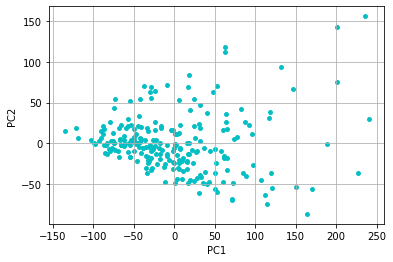

In [18]:
pca = sklearnPCA(n_components=2)

x = StandardScaler().fit_transform(ICGC_data)

Y1 = pca.fit_transform(x)

fig, ax = plt.subplots()#figsize=(20,8))

ax.scatter(Y1[:,0], Y1[:,1],color="#01BFC4",s=15)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()

# TCGA

metadata.cart.2021-12-03.json

In [12]:
df = pd.read_json('metadata.cart.2021-12-03.json')
DF = df[df['data_category'].str.contains('Transcriptome Profiling')].reset_index().drop(columns=["index"])
DF

,data_format,access,associated_entities,file_name,submitter_id,data_category,analysis,file_size,md5sum,file_id,data_type,state,experimental_strategy,annotations,downstream_analyses,platform,index_files
0,TXT,open,[{'entity_submitter_id': 'TCGA-DD-AAD8-01A-11R...,c395b751-dbb2-4efb-8e7b-5d000a456cdc.htseq.cou...,c395b751-dbb2-4efb-8e7b-5d000a456cdc_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",246031,0341a26cea7af7342ba0d497adc546e9,85c4cd93-e675-4dd2-a85a-2760c41f9d9d,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
1,TXT,open,[{'entity_submitter_id': 'TCGA-O8-A75V-01A-11R...,0961790c-f494-4fc4-8ffa-dd895bc9efca.htseq.cou...,0961790c-f494-4fc4-8ffa-dd895bc9efca_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",246074,a67ad77fcb56fb96d60169f692290ae2,ab8ec9dd-c9ac-442e-8e4b-2f3c7923954a,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
2,TXT,open,[{'entity_submitter_id': 'TCGA-CC-A9FS-01A-11R...,fb94b719-4a43-4090-9a61-9f62a30d545d.htseq.cou...,fb94b719-4a43-4090-9a61-9f62a30d545d_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",247140,8fe1c5c533ee16529426e02387594d38,247237d8-4070-422b-a863-650b0b3b3a21,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
3,TXT,open,[{'entity_submitter_id': 'TCGA-DD-AACK-01A-11R...,ae7ee00f-b6a1-4872-8375-c87d9460a7fb.htseq.cou...,ae7ee00f-b6a1-4872-8375-c87d9460a7fb_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",255448,d10b37fe96253ea671a8d65ada35ceea,a5fdc040-0557-4551-8b02-1bfac8889c59,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
4,TXT,open,[{'entity_submitter_id': 'TCGA-DD-A39Z-11A-21R...,84e37eb7-3a48-4115-803a-481080a0a4f9.htseq.cou...,84e37eb7-3a48-4115-803a-481080a0a4f9_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",242010,daeb5a9d7c349c23fe76f6109124a5f1,9e95d141-0f3f-4360-8d1d-79eb75b7421e,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,TXT,open,[{'entity_submitter_id': 'TCGA-G3-A7M5-01A-11R...,b1a96999-3357-4e09-bdd4-e6c7ed1575d5.htseq.cou...,b1a96999-3357-4e09-bdd4-e6c7ed1575d5_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",244275,febfeeb1b686acf30d20eecac9f279a0,b2417dca-ff56-4020-b012-ffa66ad2f938,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
424,TXT,open,[{'entity_submitter_id': 'TCGA-MI-A75G-01A-11R...,1c77ba3f-fb74-40ef-b22c-81d8edc19273.htseq.cou...,1c77ba3f-fb74-40ef-b22c-81d8edc19273_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",246245,bd3d4b17186faebca20f77893a528dd9,d0d1b542-a279-4fe7-b912-023ecfb3a6fe,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
425,TXT,open,[{'entity_submitter_id': 'TCGA-DD-A113-01A-11R...,1ef98734-2278-4169-bb7b-8a1d325af20d.htseq.cou...,1ef98734-2278-4169-bb7b-8a1d325af20d_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",249799,592dc8853679bce5378a34664bf78f4a,d0b7bbb7-6222-45cb-9284-5ce2f039f376,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN
426,TXT,open,[{'entity_submitter_id': 'TCGA-ED-A8O5-01A-11R...,6f78b01c-d83f-4970-8e9e-e3d78c265fc2.htseq.cou...,6f78b01c-d83f-4970-8e9e-e3d78c265fc2_count,Transcriptome Profiling,"{'workflow_version': 'v1', 'input_files': [{'d...",247006,6f015e7ff7486a7aa4911c54211ef36a,9d92149f-5c1f-4ee2-bb8b-04de14bd0092,Gene Expression Quantification,released,RNA-Seq,NaN,NaN,NaN,NaN


In [13]:
d = dict()
for i in range(len(DF["associated_entities"].values)):
    temp = []
    for key,item in DF.iloc[i,[2]]["associated_entities"][0].items():
        
        if key == "entity_submitter_id":
            temp.append(str(item)[:-16])
            
    file = DF.iloc[i,[3]]["file_name"]
    
    if str(file)[-16:]==".htseq.counts.gz":
        temp.append(DF.iloc[i,[3]]["file_name"])
    ##########################################################################
    #Zbog nekog razloga fali ime file-a za taj key.
    else:
        temp.append("9700948e-21f5-42ae-9cb5-f18c745887ce.htseq.counts.gz")
    ##########################################################################
    
    d[temp[0]]=temp[1]
    

In [14]:
files = pd.DataFrame(d.items(), columns=['case_submitter_id', 'file_name'])
files

col_one_list = files['file_name'].tolist()
col_one_list

s = set()
for dirs in col_one_list:
    #print(dirs)
    s.add(dirs)

print(len(s))

371


gdc_download tar.gz

In [15]:
import os
import pandas as pd
rootdir = 'TCGA/'

data=[]
patient_id=[]
for index,(subdir, dirs, files) in tqdm(enumerate(os.walk(rootdir))):
    for file in files:
        #print(file)
        if file in s:#file.endswith('gz'):
            patient_id.append(str(file)[:-16])
            df = pd.read_csv(subdir+"/"+file, compression='gzip',names=["gene_id","raw_read_count"],sep="\t")
            df.drop(df.tail(5).index,inplace=True)
            data.append(df)

425it [00:13, 31.90it/s]


In [16]:
tcga_data=[]
for p in tqdm(data):
    
    p = pd.merge(p,GTF,on="gene_id").sort_values(by=['gene_name']).reset_index().drop(columns=["index"])
   
    df = p[["gene_name","raw_read_count","length"]]

    gene_list = df["gene_name"].values
    mpatient = pd.DataFrame(df[["raw_read_count"]].values)
    pt = mpatient.T.set_axis(gene_list, axis=1, inplace=False)
    newp = pt.loc[:,~pt.columns.duplicated()]
    
    tcga_data.append(newp)

100%|██████████| 371/371 [00:44<00:00,  8.43it/s]


In [17]:
TCGA_data = pd.concat(tcga_data).reset_index().drop(columns=["index"])
TCGA_data = TCGA_data.reindex(sorted(TCGA_data.columns), axis=1)
TCGA_data

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
0,0,0,0,7224,131,9739,64496,75,0,0,...,0,0,0,2,0,0,0,0,0,0
1,0,0,0,137,12,13213,9033,68,7,0,...,0,0,0,1,0,0,0,0,9,0
2,0,0,0,6333,68,6452,16940,17,2,0,...,0,0,0,2,0,0,0,0,0,0
3,0,0,0,4134,82,9760,11305,72,63,0,...,1,0,0,0,0,0,0,0,2,0
4,0,2,0,13489,88,9991,112407,44,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,0,0,0,4704,100,7501,32116,35,0,0,...,0,0,0,1,0,0,0,0,1,0
367,0,0,0,10406,97,9139,75365,29,0,0,...,0,0,0,1,0,0,0,0,0,0
368,0,0,0,3931,127,6666,244504,143,2,0,...,0,0,0,3,0,0,0,0,3,0
369,0,0,0,2214,86,7663,57503,69,2,0,...,1,0,1,1,0,0,0,0,9,0


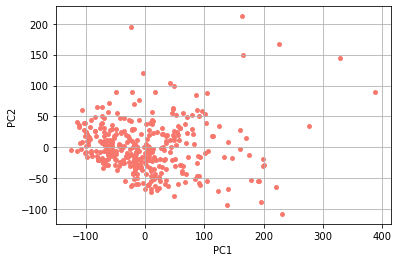

In [20]:
pca = sklearnPCA(n_components=2)

x = StandardScaler().fit_transform(TCGA_data)

Y1 = pca.fit_transform(x)

fig, ax = plt.subplots()#figsize=(20,8))

ax.scatter(Y1[:,0], Y1[:,1],color="#F8776D",s=15)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()

# COMBINE DATASETS

In [21]:
#https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [24]:

X1 = pd.DataFrame(StandardScaler().fit_transform(TCGA_data)).set_axis(TCGA_data.columns, axis=1, inplace=False)

X2 = pd.DataFrame(StandardScaler().fit_transform(ICGC_data)).set_axis(ICGC_data.columns, axis=1, inplace=False)


dataset1 = pd.concat([X1,X2], axis=0).fillna(0)
dataset1

,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
0,-0.051988,-0.055380,-0.051988,0.639670,0.610669,0.153640,-0.478277,-0.066295,-0.434065,-0.128212,...,-0.237962,-0.069824,-0.148454,-0.037332,0.0,-0.051988,-0.139858,-0.051988,-0.754559,-0.158954
1,-0.051988,-0.055380,-0.051988,-1.116323,-1.098282,0.814199,-0.843340,-0.189625,0.480182,-0.128212,...,-0.237962,-0.069824,-0.148454,-0.422059,0.0,-0.051988,-0.139858,-0.051988,1.376974,-0.158954
2,-0.051988,-0.055380,-0.051988,0.418901,-0.294070,-0.471362,-0.791296,-1.088172,-0.172851,-0.128212,...,-0.237962,-0.069824,-0.148454,-0.037332,0.0,-0.051988,-0.139858,-0.051988,-0.754559,-0.158954
3,-0.051988,-0.055380,-0.051988,-0.125960,-0.093017,0.157633,-0.828386,-0.119151,7.794157,-0.128212,...,3.157572,-0.069824,-0.148454,-0.806786,0.0,-0.051988,-0.139858,-0.051988,-0.280885,-0.158954
4,-0.051988,0.019197,-0.051988,2.191990,-0.006851,0.201556,-0.162922,-0.612471,-0.303458,-0.128212,...,-0.237962,-0.069824,-0.148454,-0.806786,0.0,-0.051988,-0.139858,-0.051988,-0.517722,-0.158954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.000000,0.000000,0.000000,-1.118986,-1.027575,-1.406364,-0.445183,0.000000,-0.090326,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
228,0.000000,0.000000,0.000000,-1.123807,-1.051141,-0.987551,-0.810032,0.000000,-0.091511,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
229,0.000000,0.000000,0.000000,-0.012944,0.151319,4.120120,-0.593135,0.000000,-0.090397,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
230,0.000000,0.000000,0.000000,-0.926910,-0.821172,-0.671822,-0.803423,0.000000,-0.091511,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


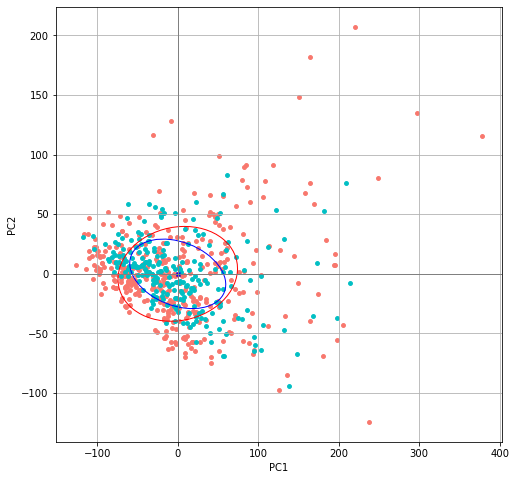

In [26]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(dataset1)

#####################################################################

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

#####################################################################

x2 = Y[371:,0]
y2 = Y[371:,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

#####################################################################

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# GEO set
## GSE14520

GSE14520.expression.matrix.csv

In [27]:
c = pd.read_csv('GSE14520.expression.matrix.csv')
c

,GSM362958,GSM362959,GSM362960,GSM362961,GSM362962,GSM362963,GSM362964,GSM362965,GSM362966,GSM362967,...,GSM712533,GSM712534,GSM712535,GSM712536,GSM712537,GSM712538,GSM712539,GSM712540,GSM712541,GSM712542
0,6.876,7.648,7.915,6.662,7.124,6.799,6.981,6.634,7.390,6.488,...,6.457,6.557,7.448,6.452,6.866,7.385,7.566,6.926,7.344,7.387
1,4.651,4.283,4.250,4.105,3.928,3.879,4.136,4.634,4.481,4.258,...,4.108,4.134,4.152,3.666,3.987,3.873,4.276,4.244,3.463,4.511
2,6.775,3.796,3.380,4.483,3.639,3.717,3.756,4.069,3.674,3.837,...,4.072,4.022,3.893,4.217,3.902,4.116,3.748,3.920,3.705,3.958
3,5.578,6.213,5.579,6.590,6.151,6.117,5.818,6.435,5.780,5.814,...,5.834,6.091,5.734,5.667,6.284,5.611,5.724,5.942,5.505,5.305
4,3.195,3.269,3.467,3.547,3.328,3.313,3.377,3.347,3.189,3.319,...,3.126,3.225,3.081,2.968,3.024,3.246,3.029,3.076,3.017,3.044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22263,3.186,3.300,3.737,3.281,3.414,3.395,3.217,3.268,3.269,3.412,...,3.240,3.231,4.834,3.620,3.423,3.227,3.496,4.315,3.208,4.111
22264,3.423,3.705,3.719,3.837,3.567,3.453,3.436,3.665,3.447,3.789,...,3.423,3.846,6.101,4.113,3.592,3.416,4.194,4.870,3.859,4.869
22265,3.178,3.553,3.488,3.448,3.432,3.291,3.415,3.179,3.205,3.415,...,3.045,3.208,3.010,3.177,3.125,2.985,3.171,3.155,3.086,3.880
22266,3.121,3.449,3.290,3.388,3.299,3.353,3.132,3.364,3.224,3.333,...,3.063,3.360,3.052,3.166,3.128,3.208,3.017,3.044,3.260,3.088


41586_2011_BFnature10350_MOESM321_ESM.xls

In [28]:
#metabolicki geni
df = pd.ExcelFile('41586_2011_BFnature10350_MOESM321_ESM.xls').parse('All metabolic genes') #you could add index_col=0 if there's an index
gene_set0=set()
for cell in df['Gene Symbol']:
    gene_set0.add(cell)   

In [29]:
MG = pd.DataFrame(gene_set0).rename(columns={0: 'Gene Symbol'})
MG

,Gene Symbol
0,PFAS
1,AOX1
2,MTTP
3,MANEAL
4,PIK3CG
...,...
2746,SLC27A1
2747,SLC35F2
2748,GPAM
2749,KCTD16


genes.csv

In [67]:
genes = pd.read_csv('genes.csv')

genes = genes.rename(columns={"symbols": 'Gene Symbol'})
genes

,Gene Symbol
0,DDR1
1,RFC2
2,HSPA6
3,PAX8
4,GUCA1A
...,...
22263,NaN
22264,NaN
22265,NaN
22266,NaN


In [33]:
p = pd.merge(genes,MG,on="Gene Symbol")
P = p.drop_duplicates().sort_values(by=['Gene Symbol'])
P

,Gene Symbol
2786,A4GALT
3005,A4GNT
2650,AACS
1224,AADAC
1550,AANAT
...,...
2208,WWOX
2142,XDH
1811,XYLB
2424,XYLT1


In [51]:
C = c.iloc[P.index.tolist()].reset_index().drop(columns=["index"])
GEO_data = C.T.set_axis(P["Gene Symbol"].tolist(), axis=1, inplace=False)

GEO_data

,A4GALT,A4GNT,AACS,AADAC,AANAT,AASDHPPT,AASS,ABAT,ABCA1,ABCA12,...,UXS1,VDAC1,VDAC2,VDAC3,VKORC1,WWOX,XDH,XYLB,XYLT1,XYLT2
GSM362958,3.738,4.499,6.207,6.931,9.250,4.534,9.711,5.586,9.637,4.158,...,5.664,4.719,8.072,6.137,8.405,5.961,7.250,7.327,6.672,4.779
GSM362959,3.722,4.483,5.776,6.627,8.581,4.676,7.461,4.589,8.426,5.601,...,6.597,3.857,8.100,5.256,8.136,5.528,7.423,5.525,5.057,5.084
GSM362960,3.602,4.067,6.665,6.150,9.716,4.173,7.775,5.850,7.708,7.449,...,6.692,3.859,7.537,4.987,8.053,5.931,8.251,7.458,5.580,4.771
GSM362961,3.714,4.673,5.768,5.436,9.116,4.345,9.623,3.990,7.374,8.836,...,4.759,4.764,5.753,5.165,8.907,6.134,7.757,5.864,5.020,5.581
GSM362962,3.433,4.363,6.531,5.551,8.675,4.694,10.299,5.797,8.344,8.692,...,5.944,6.241,6.913,5.456,9.463,6.375,8.250,7.284,5.408,4.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM712538,3.198,4.993,6.825,5.084,8.708,5.302,8.842,7.642,8.025,10.235,...,5.274,6.823,6.947,7.037,9.539,5.967,8.518,6.788,4.656,5.491
GSM712539,3.214,4.653,8.165,6.318,10.179,3.881,9.352,6.145,8.685,6.302,...,5.321,5.622,8.537,7.451,9.958,6.001,8.443,6.675,5.425,5.366
GSM712540,3.320,5.484,7.629,4.883,8.254,4.080,9.871,7.186,7.880,9.350,...,5.316,6.165,6.685,6.518,9.958,6.107,8.316,6.799,5.390,5.417
GSM712541,3.319,5.294,6.791,4.802,9.476,4.044,9.745,6.618,7.677,9.365,...,5.946,7.559,7.192,7.105,9.630,6.680,8.257,7.598,5.473,5.811


# ALL DATASETS

In [52]:
common_genes = sorted(list(set.intersection(set(TCGA_data.columns),set(ICGC_data.columns),set(GEO_data.columns))))
len(common_genes)

1934

In [53]:
#x1 = tcga[common_genes]

x1 = StandardScaler().fit_transform(TCGA_data[common_genes])

X1 = pd.DataFrame(x1)

X1 = X1.set_axis(common_genes, axis=1, inplace=False)


x2 = StandardScaler().fit_transform(ICGC_data[common_genes])

X2 = pd.DataFrame(x2)

X2 = X2.set_axis(common_genes, axis=1, inplace=False)




x3 = StandardScaler().fit_transform(GEO_data[common_genes])

X3 = pd.DataFrame(x3)

X3 = X3.set_axis(common_genes, axis=1, inplace=False)



ALL = pd.concat([X1,X2,X3], axis=0).fillna(0)
ALL

,A4GALT,A4GNT,AACS,AADAC,AANAT,AASDHPPT,AASS,ABAT,ABCA1,ABCA12,...,UXS1,VDAC1,VDAC2,VDAC3,VKORC1,WWOX,XDH,XYLB,XYLT1,XYLT2
0,-0.570361,-0.142401,-0.544746,-0.223250,-0.262799,0.621655,-0.232887,-0.450004,0.308427,-0.170785,...,1.235510,-0.574850,-0.373717,0.395337,-1.384420,-0.854438,-0.190971,0.580432,-0.443751,-0.537600
1,-0.493708,-0.076272,1.536710,-0.592495,-0.150989,-0.320583,-0.529067,-0.784163,1.954646,5.886599,...,-0.155984,-0.104166,2.439803,0.672521,0.121199,-0.318981,0.102826,-0.630125,0.331128,2.657415
2,-0.110445,-0.188692,-0.715694,-0.004161,-0.262799,0.002957,-0.049311,-0.133703,-0.780261,-0.194309,...,-0.751765,-1.043790,-0.488746,-0.239389,0.940173,-0.295183,-0.616588,-0.903477,-0.377160,-0.642781
3,-0.387246,-0.188692,-0.734840,1.120992,-0.039179,-0.153137,0.551238,0.135891,-0.996944,-0.006119,...,0.042944,-0.232471,-0.414616,0.123239,0.782842,0.296795,1.718244,-0.025280,-0.213709,1.515278
4,0.225975,-0.188692,-0.510557,0.145833,-0.150989,-0.346125,-0.537256,0.327955,-0.566825,-0.159024,...,-0.357927,-0.183137,0.641945,-0.826307,2.464696,-0.292208,0.154435,0.942298,0.058710,-0.166374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,-0.695445,0.310438,-0.074634,-0.656162,-0.495441,0.904642,-0.300598,1.148487,-0.402739,1.304379,...,-0.649725,0.736154,-0.558505,0.826525,0.445979,-0.367764,0.619727,0.027207,-0.862223,0.751333
441,-0.627361,-0.651140,1.940037,0.749037,1.164689,-1.215727,0.201350,-0.462911,0.580073,-0.504100,...,-0.566702,-0.574419,1.327928,1.373397,0.871811,-0.284147,0.469503,-0.102202,0.222956,0.480974
442,-0.176309,1.699070,1.134169,-0.885048,-1.007812,-0.918786,0.712155,0.657641,-0.618659,0.897437,...,-0.575534,0.018122,-0.869351,0.140953,0.871811,-0.023460,0.215125,0.039805,0.173566,0.591280
443,-0.180564,1.161717,-0.125752,-0.977286,0.371303,-0.972504,0.588144,0.046235,-0.920948,0.904334,...,0.537339,1.539303,-0.267828,0.916349,0.538463,1.385727,0.096949,0.954833,0.290692,1.443451


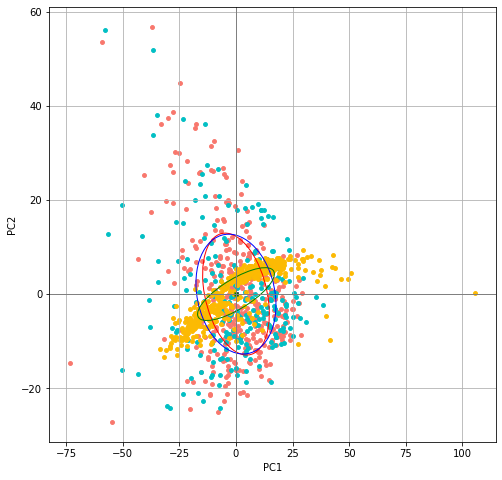

In [50]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(ALL)

#####################################################################

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

#####################################################################

x2 = Y[371:603,0]
y2 = Y[371:603,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

#####################################################################

x3 = Y[603:,0]
y3 = Y[603:,1]

mu_x3 = np.mean(x3)
mu_y3 = np.mean(y3)

ax.scatter(x3, y3, s=15,color = "#fcba03")
confidence_ellipse(x3, y3, ax,n_std=1, edgecolor='green')
ax.scatter(mu_x3, mu_y3, c='green', s=15,marker="x")

#####################################################################

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

# BATCH EFFECT

In [62]:
from combat.pycombat import pycombat

print(np.shape(ALL),
      np.shape(X1.astype(float)),
      np.shape(X2.astype(float)),
      np.shape(X3.astype(float)))

df = ALL.T

dataset1 = X1.astype(float).T
dataset2 = X2.astype(float).T
dataset3 = X3.astype(float).T

print(np.shape(dataset1),np.shape(dataset2),np.shape(dataset3))

df_expression = pd.concat([dataset1,dataset2,dataset3],join="inner",axis=1)

batch = []
datasets = [dataset1,dataset2,dataset3]

for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])
    
print(np.shape(batch))

df_corrected = pycombat(df_expression,batch)

print("end")

(1048, 1934) (371, 1934) (232, 1934) (445, 1934)
(1934, 371) (1934, 232) (1934, 445)
(1048,)
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
end


/home/sven/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/sven/anaconda3/lib/python3.8/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in true_divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


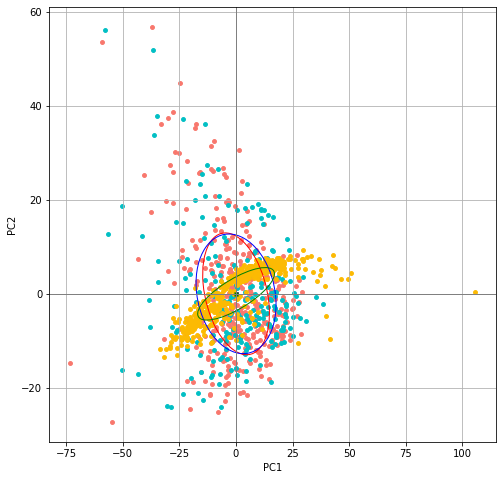

In [64]:
fig, ax = plt.subplots(figsize=(8,8))

pca = sklearnPCA(n_components=2)

Y = pca.fit_transform(df_corrected.T)

#####################################################################

x1 = Y[:371,0]
y1 = Y[:371,1]

mu_x1 = np.mean(x1)
mu_y1 = np.mean(y1)
    
ax.scatter(x1, y1, s=15,color = "#F8776D")
confidence_ellipse(x1, y1, ax,n_std=1, edgecolor='red')
ax.scatter(mu_x1, mu_y1, c='red', s=15,marker="x")

#####################################################################

x2 = Y[371:603,0]
y2 = Y[371:603,1]

mu_x2 = np.mean(x2)
mu_y2 = np.mean(y2)

ax.scatter(x2, y2, s=15,color = "#01BFC4")
confidence_ellipse(x2, y2, ax,n_std=1, edgecolor='blue')
ax.scatter(mu_x2, mu_y2, c='blue', s=15,marker="x")

#####################################################################

x3 = Y[603:,0]
y3 = Y[603:,1]

mu_x3 = np.mean(x3)
mu_y3 = np.mean(y3)

ax.scatter(x3, y3, s=15,color = "#fcba03")
confidence_ellipse(x3, y3, ax,n_std=1, edgecolor='green')
ax.scatter(mu_x3, mu_y3, c='green', s=15,marker="x")

#####################################################################

ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()